In [1]:

# SpaceInvaders DQN - Entrenamiento en CPU con checkpoints (sin matplotlib)

from __future__ import division
import numpy as np
import gym
import json
import os
import glob
from PIL import Image, ImageDraw
from IPython.display import display

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Convolution2D, Permute
from tensorflow.keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.callbacks import ModelIntervalCheckpoint, FileLogger, Callback

from IPython.display import display, HTML

In [2]:
# Configuración
INPUT_SHAPE = (84, 84)
WINDOW_LENGTH = 4
ENV_NAME = 'SpaceInvaders-v0'
MODEL_DIR = './models/'
LOG_DIR = './logs/'

# class EpisodeRewardLogger(Callback):
#     def __init__(self):
#         self.episode_rewards = []

#     def on_episode_end(self, episode, logs={}):
#         self.episode_rewards.append(logs.get('episode_reward'))

# Cargar automáticamente el último checkpoint si existe
def get_latest_weights(model_dir):
    #weights_files = glob.glob(os.path.join(model_dir, 'dqn_weights_*.h5f'))
    weights_files = glob.glob(os.path.join(model_dir, 'dqn_weights_*.h5f.index'))
    print(weights_files)
    if not weights_files:
        print("No se encontraron checkpoints previos.")
        return None
    latest_file = max(weights_files, key=os.path.getctime)
    latest_file = latest_file.replace('.index', '')
    print("Cargando pesos desde:", latest_file)
    return latest_file

latest_weights = get_latest_weights(MODEL_DIR)

env = gym.make(ENV_NAME)
np.random.seed(123)
env.seed(123)
nb_actions = env.action_space.n

class AtariProcessor(Processor):
    def process_observation(self, observation):
        assert observation.ndim == 3
        img = Image.fromarray(observation)
        img = img.resize(INPUT_SHAPE).convert('L')
        return np.array(img).astype('uint8')

    def process_state_batch(self, batch):
        return batch.astype('float32') / 255.

    def process_reward(self, reward):
        return np.clip(reward, -1., 1.)

# Red neuronal
model = Sequential()
model.add(Permute((2, 3, 1), input_shape=(WINDOW_LENGTH,) + INPUT_SHAPE))
model.add(Convolution2D(32, (8, 8), strides=(4, 4)))
model.add(Activation('relu'))
model.add(Convolution2D(64, (4, 4), strides=(2, 2)))
model.add(Activation('relu'))
model.add(Convolution2D(64, (3, 3), strides=(1, 1)))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))

# Memoria y política
memory = SequentialMemory(limit=1_000_000, window_length=WINDOW_LENGTH)
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), 
                              attr='eps', 
                              value_max=1.0,
                              value_min=0.1, 
                              value_test=0.01, 
                              nb_steps=100_000)

dqn = DQNAgent(model=model, 
               nb_actions=nb_actions, 
               policy=policy, memory=memory,
               processor=AtariProcessor(), 
               enable_double_dqn=True,
               nb_steps_warmup=5_000,
               gamma=0.99, 
               target_model_update=50_000, 
               train_interval=4,
               delta_clip=1.0)
dqn.compile(Adam(learning_rate=0.0001), metrics=['mae'])

# Callbacks
checkpoint = ModelIntervalCheckpoint(MODEL_DIR + 'dqn_weights_{step}.h5f', interval=10000)
logger = FileLogger(LOG_DIR + 'dqn_log.json', interval=100)

# Si hay pesos anteriores, cargarlos antes de seguir
if latest_weights:
    dqn.load_weights(latest_weights)
    print('Hay pesos anteriores y se van a cargar')

# reward_logger = EpisodeRewardLogger()

# Entrenamiento (ajusta nb_steps según necesites)
dqn.fit(env, nb_steps=100_000, visualize=False, verbose=2, callbacks=[checkpoint, logger])
# dqn.fit(env, nb_steps=250_000, visualize=False, verbose=2, callbacks=[checkpoint, logger, reward_logger])

# Guardar pesos finales
dqn.save_weights(MODEL_DIR + 'dqn_final_weights.h5f', overwrite=True)

print('########################################################')
print('PROCESO TERMINADO')
print('########################################################')


['./models\\dqn_weights_10000.h5f.index', './models\\dqn_weights_100000.h5f.index', './models\\dqn_weights_1000000.h5f.index', './models\\dqn_weights_110000.h5f.index', './models\\dqn_weights_120000.h5f.index', './models\\dqn_weights_130000.h5f.index', './models\\dqn_weights_140000.h5f.index', './models\\dqn_weights_150000.h5f.index', './models\\dqn_weights_160000.h5f.index', './models\\dqn_weights_170000.h5f.index', './models\\dqn_weights_180000.h5f.index', './models\\dqn_weights_190000.h5f.index', './models\\dqn_weights_20000.h5f.index', './models\\dqn_weights_200000.h5f.index', './models\\dqn_weights_210000.h5f.index', './models\\dqn_weights_220000.h5f.index', './models\\dqn_weights_230000.h5f.index', './models\\dqn_weights_240000.h5f.index', './models\\dqn_weights_250000.h5f.index', './models\\dqn_weights_260000.h5f.index', './models\\dqn_weights_270000.h5f.index', './models\\dqn_weights_280000.h5f.index', './models\\dqn_weights_290000.h5f.index', './models\\dqn_weights_30000.h5f.i

C:\Users\Rociniel\Anaconda3\envs\miar_rl\lib\site-packages\tensorflow\python\keras\engine\training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


   420/100000: episode: 1, duration: 4.383s, episode steps: 420, steps per second:  96, episode reward:  6.000, mean reward:  0.014 [ 0.000,  1.000], mean action: 2.467 [0.000, 5.000],  loss: --, mae: --, mean_q: --, mean_eps: --
  1242/100000: episode: 2, duration: 7.695s, episode steps: 822, steps per second: 107, episode reward: 12.000, mean reward:  0.015 [ 0.000,  1.000], mean action: 2.418 [0.000, 5.000],  loss: --, mae: --, mean_q: --, mean_eps: --
  1870/100000: episode: 3, duration: 5.536s, episode steps: 628, steps per second: 113, episode reward:  9.000, mean reward:  0.014 [ 0.000,  1.000], mean action: 2.419 [0.000, 5.000],  loss: --, mae: --, mean_q: --, mean_eps: --
  2558/100000: episode: 4, duration: 5.043s, episode steps: 688, steps per second: 136, episode reward: 11.000, mean reward:  0.016 [ 0.000,  1.000], mean action: 2.360 [0.000, 5.000],  loss: --, mae: --, mean_q: --, mean_eps: --
  2954/100000: episode: 5, duration: 2.281s, episode steps: 396, steps per secon

C:\Users\Rociniel\Anaconda3\envs\miar_rl\lib\site-packages\tensorflow\python\keras\engine\training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


  5580/100000: episode: 9, duration: 45.479s, episode steps: 1023, steps per second:  22, episode reward: 16.000, mean reward:  0.016 [ 0.000,  1.000], mean action: 2.480 [0.000, 5.000],  loss: 0.021064, mae: 2.892812, mean_q: 3.482731, mean_eps: 0.952390
  6622/100000: episode: 10, duration: 65.970s, episode steps: 1042, steps per second:  16, episode reward:  7.000, mean reward:  0.007 [ 0.000,  1.000], mean action: 2.476 [0.000, 5.000],  loss: 0.016070, mae: 2.846563, mean_q: 3.430616, mean_eps: 0.945100
  7280/100000: episode: 11, duration: 42.836s, episode steps: 658, steps per second:  15, episode reward: 11.000, mean reward:  0.017 [ 0.000,  1.000], mean action: 2.471 [0.000, 5.000],  loss: 0.014234, mae: 2.866731, mean_q: 3.457438, mean_eps: 0.937450
  7776/100000: episode: 12, duration: 32.378s, episode steps: 496, steps per second:  15, episode reward:  5.000, mean reward:  0.010 [ 0.000,  1.000], mean action: 2.508 [0.000, 5.000],  loss: 0.016337, mae: 2.861814, mean_q: 3.45

Testing for 20 episodes ...
Episode 1: reward: 6.000, steps: 424
Episode 2: reward: 9.000, steps: 601
Episode 3: reward: 10.000, steps: 661
Episode 4: reward: 21.000, steps: 1087
Episode 5: reward: 7.000, steps: 547
Episode 6: reward: 5.000, steps: 498
Episode 7: reward: 5.000, steps: 587
Episode 8: reward: 13.000, steps: 884
Episode 9: reward: 11.000, steps: 610
Episode 10: reward: 6.000, steps: 551
Episode 11: reward: 6.000, steps: 622
Episode 12: reward: 21.000, steps: 1033
Episode 13: reward: 12.000, steps: 797
Episode 14: reward: 14.000, steps: 802
Episode 15: reward: 6.000, steps: 406
Episode 16: reward: 7.000, steps: 706
Episode 17: reward: 4.000, steps: 422
Episode 18: reward: 4.000, steps: 487
Episode 19: reward: 8.000, steps: 693
Episode 20: reward: 13.000, steps: 748

Recompensa media en test: 9.40
DATOS DE ENTRENAMIENTO

Gráfico de entrenamiento con ejes:


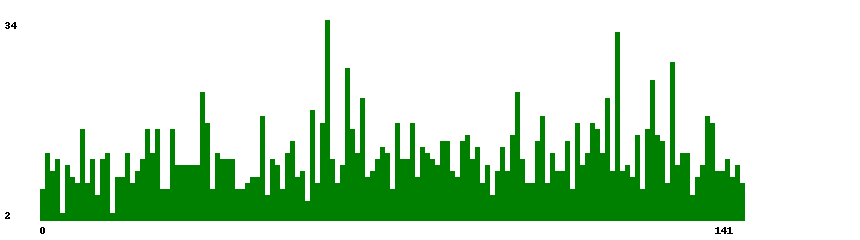

DATOS DE TEST
Gráfico de recompensas de test con ejes:


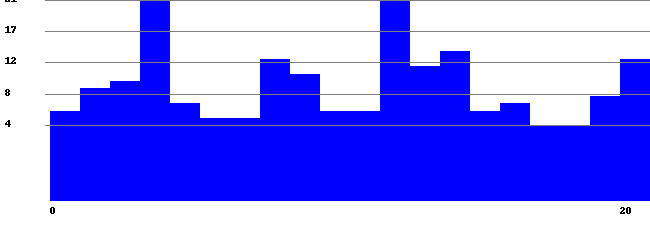

In [7]:
# Mostrar datos de ENTRENAMIENTO
def mostrar_entrenamiento(log_path = LOG_DIR + 'dqn_log.json', ancho=800, alto=200):
    with open(log_path) as f:
        data = json.load(f)

    rewards = data['episode_reward']
    if not rewards:
        print("No hay datos de entrenamiento.")
        return

    max_reward = max(rewards)
    min_reward = min(rewards)
    escalar = alto / (max_reward - min_reward + 1)

    img = Image.new('RGB', (ancho + 60, alto + 40), color='white')
    dibujar = ImageDraw.Draw(img)

    paso = max(1, ancho // len(rewards))
    offset_x = 40
    offset_y = 20

    for i, r in enumerate(rewards):
        x = offset_x + i * paso
        y = offset_y + int((max_reward - r) * escalar)
        dibujar.rectangle([x, y, x + paso - 1, alto + offset_y], fill='green')

    # Eje Y - min y max
    dibujar.text((5, offset_y), f"{max_reward:.0f}", fill='black')
    dibujar.text((5, alto + offset_y - 10), f"{min_reward:.0f}", fill='black')

    # Eje X - episodios
    dibujar.text((offset_x, alto + offset_y + 5), "0", fill='black')
    dibujar.text((offset_x + len(rewards)*paso - 30, alto + offset_y + 5),
                 f"{len(rewards)}", fill='black')

    print("Gráfico de entrenamiento con ejes:")
    display(img)

# Mostrar datos de TEST
def mostrar_test_con_ejes(rewards, ancho=600, alto=200, divisiones_y=4):
    if not rewards:
        print("No hay datos de test.")
        return

    max_reward = max(rewards)
    min_reward = min(rewards)
    rango = max_reward - min_reward if max_reward != min_reward else 1
    escalar = alto / (rango + 10)

    margen_izquierdo = 50
    margen_inferior = 30
    img = Image.new('RGB', (ancho + margen_izquierdo, alto + margen_inferior), color='white')
    dibujar = ImageDraw.Draw(img)

    paso = max(1, ancho // len(rewards))

    # Dibujar barras
    for i, r in enumerate(rewards):
        x = margen_izquierdo + i * paso
        y = int((max_reward - r) * escalar)
        dibujar.rectangle([x, y, x + paso - 1, alto], fill='blue')

    # Líneas y etiquetas en eje Y
    for i in range(divisiones_y + 1):
        valor = min_reward + i * (rango / divisiones_y)
        y = int((max_reward - valor) * escalar)
        dibujar.line([(margen_izquierdo - 5, y), (ancho + margen_izquierdo, y)], fill='gray', width=1)
        dibujar.text((5, y - 7), f"{valor:.0f}", fill='black')

    # Etiquetas en eje X
    dibujar.text((margen_izquierdo, alto + 5), "0", fill='black')
    dibujar.text((ancho + margen_izquierdo - 30, alto + 5), f"{len(rewards)}", fill='black')

    print("Gráfico de recompensas de test con ejes:")
    display(img)

#  TEST DEL AGENTE
history = dqn.test(env, nb_episodes=20, visualize=False)
test_rewards = history.history['episode_reward']
print(f"\nRecompensa media en test: {np.mean(test_rewards):.2f}")

# VISUALIZACION DE DATOS
print("DATOS DE ENTRENAMIENTO")
print()
mostrar_entrenamiento()
print("DATOS DE TEST")
mostrar_test_con_ejes(test_rewards)